In [1]:
from neuron import h
from neuron.units import mV, ms, um
import numpy as np
import plotly
from pprint import pprint
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import LFPy
import MEAutility as mu
from matplotlib.collections import LineCollection
import pwlf
import sympy

In [2]:
h.load_file("stdrun.hoc")

1.0

In [3]:
%run ZIAD_MEARecHelperFunctions.ipynb

In [4]:
def calc_B_field(cell, electrode):
    print("Calculating Magnetic Field")
    i_axial, d_vectors, pos_vectors = cell.get_axial_currents_from_vmem()
    i_axial = i_axial * 1e-9 #Convert to nA
    d_vectors = d_vectors * 1e-6 #Convert to um
    pos_vectors = pos_vectors * 1e-6 #Convert to um

    # print("Imem: ", cell.imem)
    # print("Iaxial: ", i_axial)
    # print("Imem shape: ", np.shape(cell.imem))
    # print("Iaxial shape: ", np.shape(i_axial))
    #print("CDP: ", current_dipole_moment)
    #print("CDP shape: ", np.shape(current_dipole_moment))

    #print("I_axial: ", i_axial)
    #print("D_vectors: ", d_vectors)
    #print("Pos_vectors: ", pos_vectors)

    num_elecs = len(electrode.x)
    time_len = len(cell.tvec)
    dims = 3
    all_B_fields = np.zeros((num_elecs, dims, time_len))

    for i in range(len(electrode.x)):
        R = np.array([electrode.x[i], electrode.y[i], electrode.z[i]])
        R = R * 1e-6 #Convert to um
        #print(R)
        B = calc_B_field_single_sensor(cell, R, i_axial, d_vectors, pos_vectors)
        all_B_fields[i] = B

    return all_B_fields

def calc_B_field_single_sensor(cell, R, i_axial, d_vectors, pos_vectors):
    B = np.zeros((3, cell.tvec.size))

    count = 0
    r_rel = R - pos_vectors
    cross = np.cross(d_vectors.T, r_rel)
    divisor = 1e7 * np.sqrt((r_rel**2).sum(axis=1))**3
    vec = cross / np.expand_dims(divisor, axis=0).T

    count = 0
    for ax_curr in i_axial.T:
        B[:, count] = ax_curr @ vec
        count += 1

    return B

def taper_axon(axon, nseg, start_diam, end_diam, hillock=True, hillock_length=20, hillock_mult=5):
    diams = np.arange(end_diam, start_diam+0.001, (start_diam-end_diam)/(nseg-1))
    
    if hillock:
        num_diams = round(hillock_length/ (axon.L / nseg))
        hill_diams = np.linspace(start_diam, hillock_mult*start_diam, num_diams)
        new_diams = np.arange(end_diam, start_diam+0.001, (start_diam-end_diam)/(nseg-len(hill_diams)))
        diams[-1*len(hill_diams):] = hill_diams
        diams[:len(new_diams)] = new_diams
        
    diams = np.flip(diams) 
    
    for i, seg in enumerate(axon.allseg()):
        if i > 0 and i < nseg+1:
            seg.diam = diams[i-1]

### Create cell using NEURON
- Define axon and soma
- Add Hodgkins-Huxley mechanisms
- Define geometry

In [5]:
soma = h.Section(name='soma')
soma.L = soma.diam = 20*um

axon = h.Section(name="axon")
axon.L = 1000*um
start_diam = 4
axon_diam = start_diam
axon.diam = axon_diam*um

nseg = 501
axon.nseg = nseg

soma.insert(h.hh)
axon.insert(h.hh)

axon.connect(soma(0))

axon

### Create LFPy cell to perform extracellular calculations

In [6]:
T = 50
dt = 0.03125
v_init = -65
radial_scaling = False
# Radial Scaling
dist_along_axon = 10 + 100 # 100 is distance of MEA from center

# Axial scaling
dist_from_axon = 10 + 100 # 100 is distance of MEA from center
dist_from_axon = 100 # Use this one for measuring 3-dB area

axon_hillock_setting = True
taper_axon_setting = True
axon_end_diam = 1

cell = LFPy.Cell(morphology = h.allsec(), 
                 v_init = v_init, 
                 pt3d = True, 
                 tstart = 0, 
                 dt = dt, 
                 tstop = T)

# Radial scaling
if radial_scaling == True:
    cell.set_rotation(-np.pi/2, -np.pi/2, np.pi, 'zyx')
    cell.set_pos(-10, -1*dist_along_axon, -500)

# Axial scaling
else:
    cell.set_rotation(0, -np.pi/2, np.pi, 'zyx')
    #cell.set_pos(-10, -1*dist_from_axon, -510)
    cell.set_pos(-10, -1*dist_from_axon, -250)
    
axon.nseg = nseg # Need to set this twice so imem and pt3d counts match
cell.totnsegs = soma.nseg + axon.nseg

cell._update_pt3d()

if taper_axon_setting == True:
    taper_axon(axon, nseg, axon_diam, axon_end_diam, hillock=axon_hillock_setting)

Morphology:  <all section iterator next>
Type:  <class 'hoc.HocObject'>


### Connect stimulus to soma

In [7]:
# Create synapse
syn = h.IClamp(0.5, sec=soma)
syn.dur = 60
syn.delay = 5

# Create vector to "play" stimulus into cell - can be time-varying if desired
weight = 0.75
tot_ntsteps = int(round(T / dt + 1))
I = np.ones(tot_ntsteps) * weight
#I[400:1000] = 0
noiseVec = h.Vector(I)

noiseVec.play(syn._ref_amp, dt)

Vector[0]

### Increase Density of Axon Hillock Ion Channels

In [8]:
density_mult = 4

# for i, seg in enumerate(soma.allseg()):
#     if i > 0 and i < 1:
#         seg.hh.gnabar = seg.hh.gnabar*density_mult
#         seg.hh.gkbar = seg.hh.gkbar*density_mult

for i, seg in enumerate(axon.allseg()):
    if i > 0 and seg.diam > start_diam:
        seg.hh.gnabar = seg.hh.gnabar*density_mult
        seg.hh.gkbar = seg.hh.gkbar*density_mult

### Recording Gating Variables

In [9]:
stateVars = {}
for var in ['m', 'h', 'n']:
    stateVars[var] = h.Vector()
stateVars['m'].record(soma(0.5).hh._ref_m, sec=soma)
stateVars['h'].record(soma(0.5).hh._ref_h, sec=soma)
stateVars['n'].record(soma(0.5).hh._ref_n, sec=soma)

Vector[3]

### Simulate cell

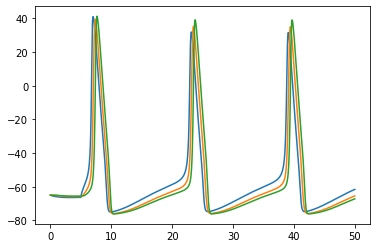

In [10]:
cell.simulate(rec_imem=True, rec_vmem=True)
t = np.arange(0, T+dt, dt)

#plt.plot(np.arange(0, T+dt, dt), cell.somav)
plt.plot(t, cell.vmem[0])
plt.plot(t, cell.vmem[int(axon.nseg*0.5)])
plt.plot(t, cell.vmem[int(axon.nseg*0.9)])

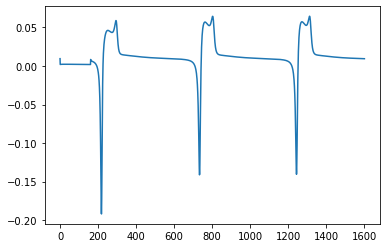

In [11]:
plt.plot(cell.imem[10])

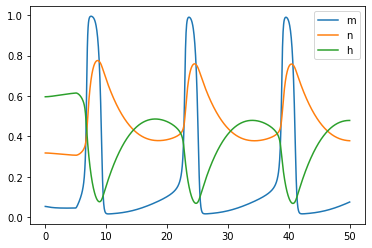

In [12]:
plt.plot(t, stateVars['m'])
plt.plot(t, stateVars['n'])
plt.plot(t, stateVars['h'])
plt.legend(['m', 'n', 'h'])

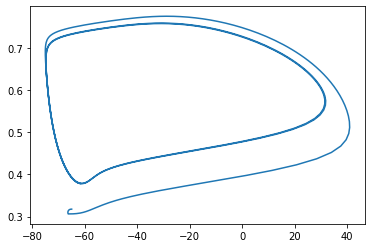

In [13]:
plt.plot(cell.vmem[0], stateVars['n'])

(1601, 1, 2)
(1600, 2, 2)


Text(0, 0.5, 'h')

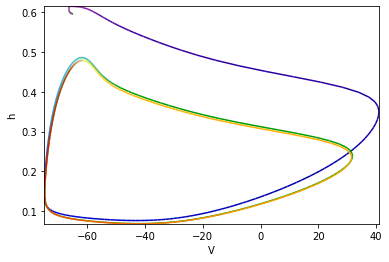

In [14]:
gateVar = 'h'

x   = cell.vmem[0] 
y   = stateVars[gateVar]
t = np.linspace(0,1,x.shape[0]) # your "time" variable

# set up a list of (x,y) points
points = np.array([x,y]).transpose().reshape(-1,1,2)
print(points.shape)  # Out: (len(x),1,2)

# set up a list of segments
segs = np.concatenate([points[:-1],points[1:]],axis=1)
print(segs.shape)  # Out: ( len(x)-1, 2, 2 )
                  # see what we've done here -- we've mapped our (x,y)
                  # points to an array of segment start/end coordinates.
                  # segs[i,0,:] == segs[i-1,1,:]

# make the collection of segments
lc = LineCollection(segs, cmap=plt.get_cmap('nipy_spectral'))
lc.set_array(t) # color the segments by our parameter

# plot the collection
plt.gca().add_collection(lc) # add the collection to the plot
plt.xlim(x.min(), x.max()) # line collections don't auto-scale the plot
plt.ylim(y.min(), y.max())

plt.xlabel('V')
plt.ylabel(gateVar)

### Calculate extracellular V

In [15]:
if radial_scaling == True:
    #mea_name = '1000MEA1'
    mea_name = '40000MEA[1, 5]'
else:
    #mea_name = '1000MEA1_Axial'
    mea_name = '40000MEA[1, 5]'
    
mea = mu.return_mea(mea_name)
electrodes = LFPy.RecExtElectrode(cell, probe=mea)

lfp = electrodes.get_transformation_matrix() @ cell.imem

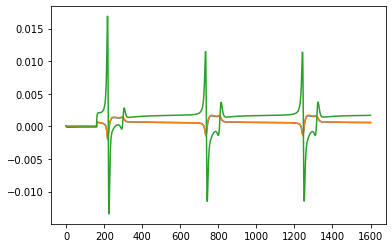

In [16]:
plt.plot(lfp[0])
plt.plot(lfp[10])
plt.plot(lfp[500])

/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_29175/3864615857.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(X, Y, '.', marker='o', markersize=3, color='k', zorder=0)
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_29175/3864615857.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([lim, lim, -lim, -lim], [lim, -lim, lim, -lim], '.', marker='o', markersize=1, color='blue')
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_29175/3864615857.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(X, Y, '.', marker='o', markersize=3, color='k', zorder=0)
/var/folders/df/rk7rf_5s4253kn_8sb1

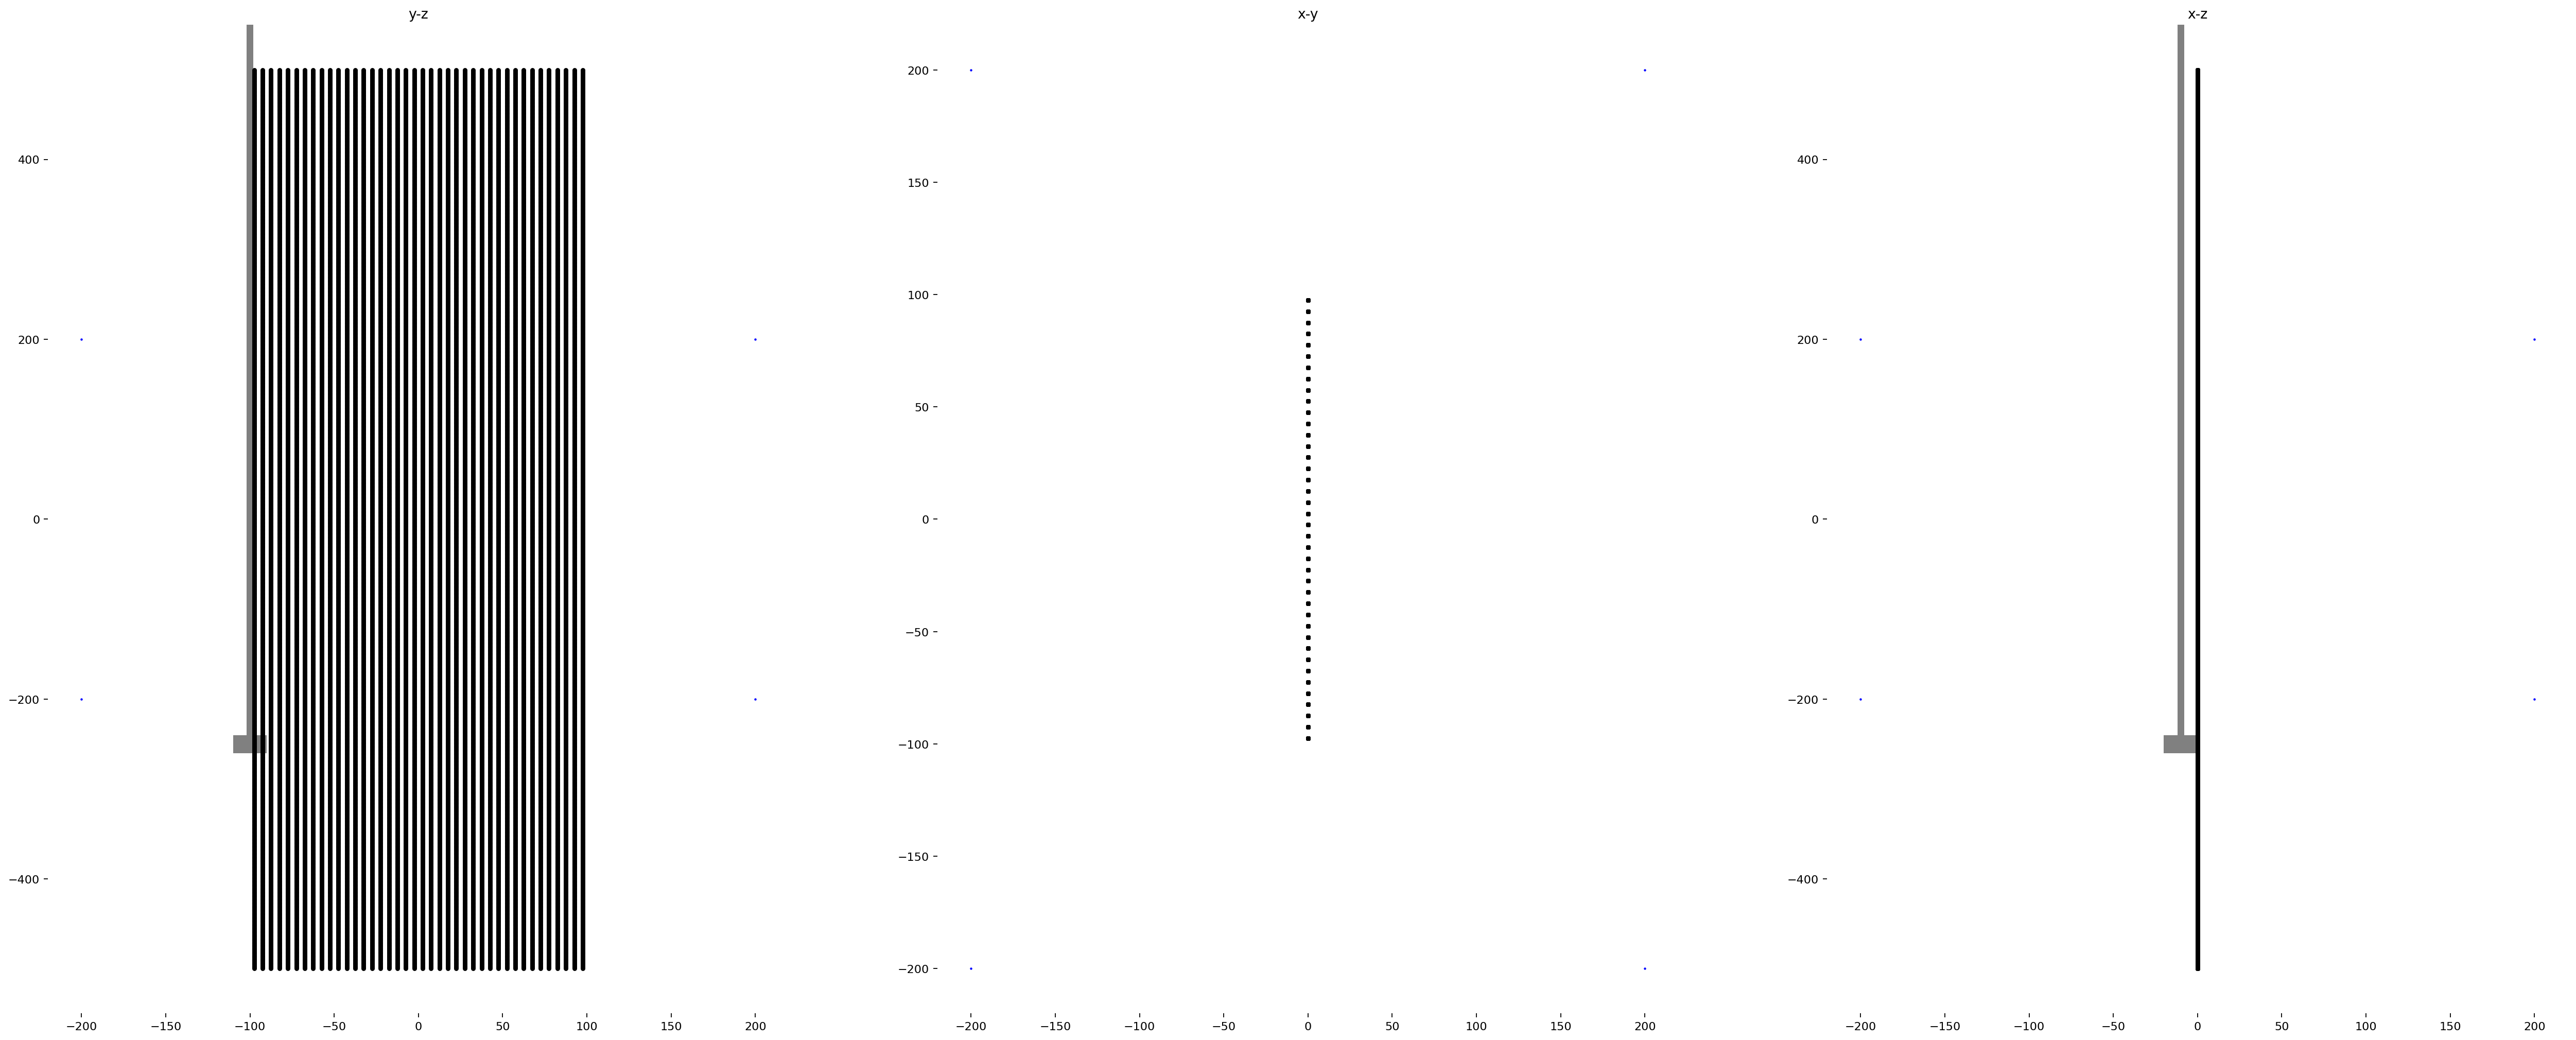

In [17]:
mea = mu.return_mea(mea_name)
electrodes = LFPy.RecExtElectrode(cell, probe=mea)

#cell.set_pos(0, 0, 0)
#cell.set_rotation(0, 0, -0.05)
#cell.set_rotation(0, 1.5, -0.05)
fig = plotcell_3planes(cell, electrodes, 200, plot_electrodes=True)

### Calculate magnetic field

In [18]:
all_B = calc_B_field(cell, electrodes)

Calculating Magnetic Field


In [19]:
# Extract spike
def get_spike_data(sig, elec=False, basic=False, ret_points=False):
    if basic == True:
        return abs(np.max(sig) - np.min(sig))
        
    sig = sig - sig[0]
    spike_max_idx = np.argmax(sig)
    spike_min_idx = np.argmin(sig)
    
    if spike_max_idx > spike_min_idx or elec==True:
        first_idx = spike_min_idx
        second_idx = np.argmax(sig[first_idx:])+first_idx
    else:
        first_idx = spike_max_idx
        second_idx = np.argmin(sig[first_idx:])+first_idx
        
    #print(first_idx, second_idx)
    #print(sig[first_idx], sig[second_idx])
    if ret_points:
        return abs(sig[first_idx] - sig[second_idx]), first_idx, second_idx
    
    return abs(sig[first_idx] - sig[second_idx])

### Calculate scaling (Single Column MEA)

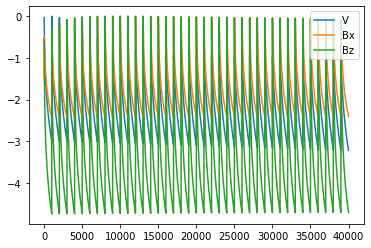

In [20]:
start_idx = 165
end_idx = 600
idxs = slice(start_idx, end_idx)

for i in [-1, 0, 2]:
    if i == -1:
        data = np.copy(lfp[:, idxs])
    else:
        data = np.copy(all_B[:, i, idxs])

    #for n in range(len(data)):
    #    data[n] = data[n] - data[n, 0]

    #data_max = np.max(abs(data), axis=1)
    #data_max = np.max(data, axis=1) - np.min(data, axis=1)
    data_max = []
    for n in range(len(data)):
        if radial_scaling:
            sig_pp = get_spike_data(np.copy(data[n]), elec=i==-1)
        else:
            sig_pp = get_spike_data(np.copy(data[n]), basic=True)
        #print(sig_pp)
        data_max.append(sig_pp)
    
    data_max = np.array(data_max)
    data_max = data_max / max(data_max)
    logdata = np.log10(data_max)
    r = electrodes.z - cell.z3d[0][0]
    logr = np.log10(r)
    roc = (logdata[1:] - logdata[:-1])/(logr[1:] - logr[:-1])
    plt.plot(logdata)

plt.legend(['V', 'Bx', 'Bz'])

### Calculate Scaling (MEA Grid)

In [20]:
np.shape(lfp)

(40000, 1601)

(10, 1000)
332


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_17783/3680319604.py:46: RuntimeWarning: invalid value encountered in log10
  logr = np.log10(r)


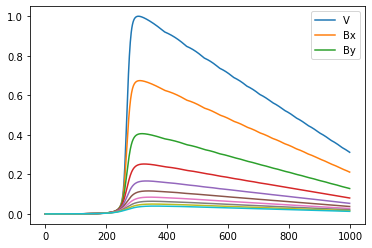

In [42]:
num_cols = len(np.unique(mea.positions[:, 1]))
num_rows = len(np.unique(mea.positions[:, 2]))

start_idx = 165
end_idx = 600
idxs = slice(start_idx, end_idx)

for i in [1]:
    all_data_max = []
    for j in range(10):
        if i == -1:
            data = np.copy(lfp[j*num_rows:(j+1)*num_rows, idxs])
        else:
            data = np.copy(all_B[j*num_rows:(j+1)*num_rows, i, idxs])

        #for n in range(len(data)):
        #    data[n] = data[n] - data[n, 0]

        #data_max = np.max(abs(data), axis=1)
        #data_max = np.max(data, axis=1) - np.min(data, axis=1)
        data_max = []
        for n in range(len(data)):
            if radial_scaling:
                sig_pp = get_spike_data(np.copy(data[n]), elec=i==-1)
            else:
                sig_pp = get_spike_data(np.copy(data[n]), basic=True)
            #print(sig_pp)
            data_max.append(sig_pp)

        data_max = np.array(data_max)
        #data_max = data_max / max(data_max)
        
        all_data_max.append(data_max)
    
    all_data_max = np.array(all_data_max)
    data_max = all_data_max / np.amax(all_data_max)
    #data_max = np.mean(all_data_max, axis=0)
    
    print(np.shape(data_max))
    
    b = len(np.where(data_max > 1/np.sqrt(2))[0])
    print(b)
    
    logdata = np.log10(data_max)
    r = electrodes.z[:num_rows] - cell.z3d[0][0]
    logr = np.log10(r)
    roc = (logdata[:, 1:] - logdata[:, :-1])/(logr[1:] - logr[:-1])
    plt.plot(data_max.T)
    
#     for n in range(np.shape(roc)[1]):
#         for w in range(np.shape(roc)[0]):
#             print(roc.T[n][w], end="\t")
#         print("")

    plt.legend(['V', 'Bx', 'By'])

In [43]:
for i in range(np.shape(data_max)[0]):
    a = len(np.where(data_max[i] > 1/np.sqrt(2))[0])
    print(a)

332
0
0
0
0
0
0
0
0
0


In [34]:
np.shape(data_max)

(10, 1000)

In [44]:
for i in range(40):
    print(f'B_IP-{i*5+10}', end="\t")

B_IP-10	B_IP-15	B_IP-20	B_IP-25	B_IP-30	B_IP-35	B_IP-40	B_IP-45	B_IP-50	B_IP-55	B_IP-60	B_IP-65	B_IP-70	B_IP-75	B_IP-80	B_IP-85	B_IP-90	B_IP-95	B_IP-100	B_IP-105	B_IP-110	B_IP-115	B_IP-120	B_IP-125	B_IP-130	B_IP-135	B_IP-140	B_IP-145	B_IP-150	B_IP-155	B_IP-160	B_IP-165	B_IP-170	B_IP-175	B_IP-180	B_IP-185	B_IP-190	B_IP-195	B_IP-200	B_IP-205	

In [54]:
for i in range(1000):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [35]:
a = [5, 4, 3, 2]
b = [6, 7, 8, 9]

c = []
c.append(a)
c.append(b)

c = np.array(c)

print(np.mean(c, axis=0))

[5.5 5.5 5.5 5.5]


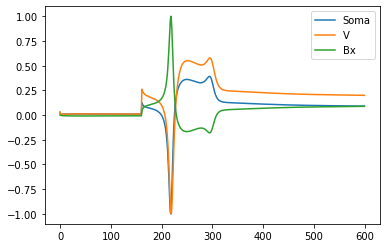

In [33]:
idx = 100
plt.plot(lfp[0, idxs]/np.max(abs(lfp[0, idxs])))
plt.plot(lfp[idx, idxs]/np.max(abs(lfp[idx, idxs])))
plt.plot(all_B[idx, 0, idxs]/np.max(abs(all_B[idx, 0, idxs])))
plt.legend(['Soma', 'V', 'Bx'])

0.0002033998389695772 57 133


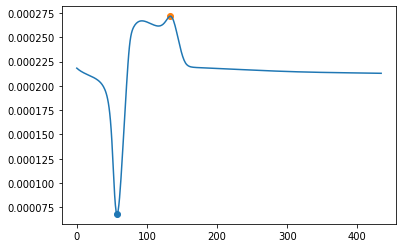

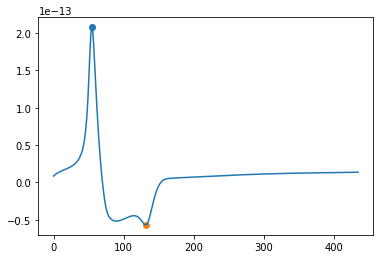

In [40]:
idx = 900
val, idx1, idx2 = get_spike_data(lfp[:, idxs][idx], elec=False, basic=False, ret_points=True)
print(val, idx1, idx2)
plt.plot(lfp[:, idxs][idx])
plt.scatter(idx1, lfp[:, idx1+start_idx][idx])
plt.scatter(idx2, lfp[:, idx2+start_idx][idx])

plt.figure()
val, idx1, idx2 = get_spike_data(all_B[:, 0, idxs][idx], elec=False, basic=False, ret_points=True)
plt.plot(all_B[:, 0, idxs][idx])
plt.scatter(idx1, all_B[:, 0, idx1+start_idx][idx])
plt.scatter(idx2, all_B[:, 0, idx2+start_idx][idx])

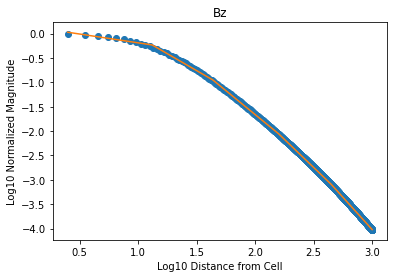

In [56]:
x = logr[2:]
y = logdata[2:]
my_pwlf = pwlf.PiecewiseLinFit(x, y)
res = my_pwlf.fit(5)

xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

plt.figure()
plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')
plt.title('Bz')
plt.ylabel('Log10 Normalized Magnitude')
plt.xlabel('Log10 Distance from Cell')
plt.show()

In [57]:
from sympy import Symbol
from sympy.utilities import lambdify
x = Symbol('x')


def get_symbolic_eqn(pwlf_, segment_number):
    if pwlf_.degree < 1:
        raise ValueError('Degree must be at least 1')
    if segment_number < 1 or segment_number > pwlf_.n_segments:
        raise ValueError('segment_number not possible')
    # assemble degree = 1 first
    for line in range(segment_number):
        if line == 0:
            my_eqn = pwlf_.beta[0] + (pwlf_.beta[1])*(x-pwlf_.fit_breaks[0])
        else:
            my_eqn += (pwlf_.beta[line+1])*(x-pwlf_.fit_breaks[line])
    # assemble all other degrees
    if pwlf_.degree > 1:
        for k in range(2, pwlf_.degree + 1):
            for line in range(segment_number):
                beta_index = pwlf_.n_segments*(k-1) + line + 1
                my_eqn += (pwlf_.beta[beta_index])*(x-pwlf_.fit_breaks[line])**k
    return my_eqn.simplify()


eqn_list = []
f_list = []
for i in range(my_pwlf.n_segments):
    eqn_list.append(get_symbolic_eqn(my_pwlf, i + 1))
    print('Equation number: ', i + 1)
    print(eqn_list[-1])
    f_list.append(lambdify(x, eqn_list[-1]))

Equation number:  1
0.169134374270146 - 0.357892885862383*x
Equation number:  2
1.30980368718004 - 1.37927292050512*x
Equation number:  3
2.25272710358006 - 1.95642516776259*x
Equation number:  4
3.00068930913419 - 2.2979156196284*x
Equation number:  5
3.9262245423814 - 2.64851602370382*x


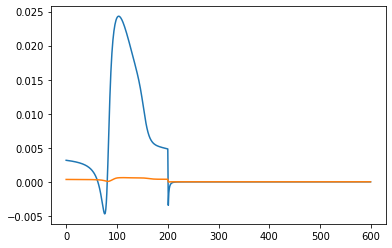

In [24]:
plt.plot(lfp[0, idxs])
plt.plot(lfp[500, idxs])

# plt.plot(lfp[40, idxs])
# plt.plot(lfp[500, idxs])
# plt.plot(lfp[800, idxs])

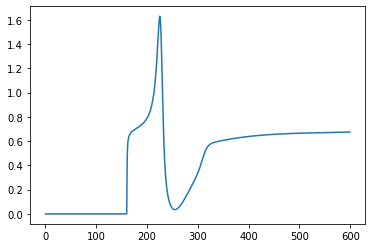

In [27]:
plt.plot(i_axial[20, idxs])

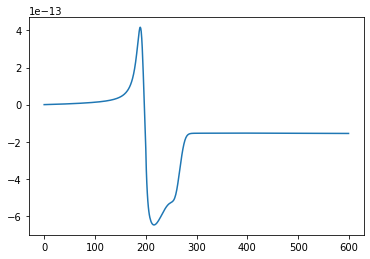

In [61]:
sig = all_B[idx, 0, idxs]-all_B[idx, 0, 600]
#plt.plot(sig[1:] - sig[:-1])
plt.plot(sig)

In [26]:
np.argmin(lfp[900, idxs]-lfp[900, 600])

201

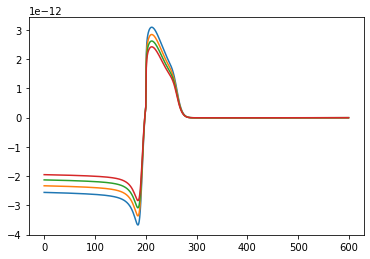

In [35]:
plt.plot(all_B[18, 2, idxs])
plt.plot(all_B[19, 2, idxs])
plt.plot(all_B[20, 2, idxs])
plt.plot(all_B[21, 2, idxs])

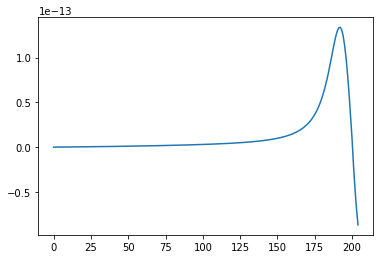

In [75]:
#plt.plot(lfp[10][idxs])
# plt.plot(data[340][:205])
# plt.plot(data[380])
# plt.plot(data[400])
# plt.plot(data[420])
# plt.plot(data[440])
plt.plot(data[900][:205])

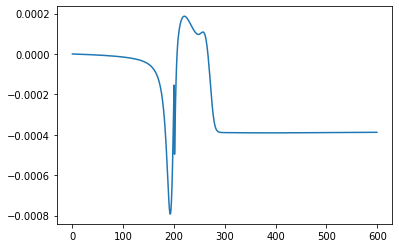

In [90]:
#plt.plot(data[10])
plt.plot(data[400])

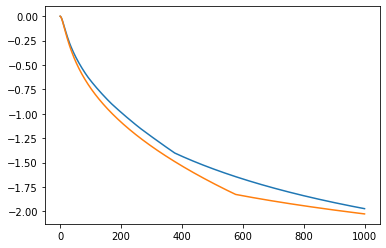

In [19]:
idxs = slice(600,1200)
v_data = lfp[:, idxs]

v_max2 = np.max(abs(v_data), axis=1)
v_max2 = v_max2 / max(v_max2)
np.shape(v_max)
plt.plot(np.log10(v_max))
plt.plot(np.log10(v_max2))

In [31]:
data = lfp[:, idxs]

for i in range(len(data)):
    if max(-1*data[i]) > max(data[i]):
        print(i, "min")
    else:
        print(i, "max")

0 min
1 min
2 min
3 min
4 min
5 min
6 min
7 min
8 min
9 min
10 min
11 min
12 min
13 min
14 min
15 min
16 min
17 min
18 min
19 min
20 min
21 min
22 min
23 min
24 min
25 min
26 min
27 min
28 min
29 min
30 min
31 min
32 min
33 min
34 min
35 min
36 min
37 min
38 min
39 min
40 min
41 min
42 min
43 min
44 min
45 min
46 min
47 min
48 min
49 min
50 min
51 min
52 min
53 min
54 min
55 min
56 min
57 min
58 min
59 min
60 min
61 min
62 min
63 min
64 min
65 min
66 min
67 min
68 min
69 min
70 min
71 min
72 min
73 min
74 min
75 min
76 min
77 min
78 min
79 min
80 min
81 min
82 min
83 min
84 min
85 min
86 min
87 min
88 min
89 min
90 min
91 min
92 min
93 min
94 min
95 min
96 min
97 min
98 min
99 min
100 min
101 min
102 min
103 min
104 min
105 min
106 min
107 min
108 min
109 min
110 min
111 min
112 min
113 min
114 min
115 min
116 min
117 min
118 min
119 min
120 min
121 min
122 min
123 min
124 min
125 min
126 min
127 min
128 min
129 min
130 min
131 min
132 min
133 min
134 min
135 min
136 min
137 min
138 mi

In [59]:
ic = h.IClamp(soma(0.5))
ic.delay = 2*ms
ic.dur = 2*ms
ic.amp = 1

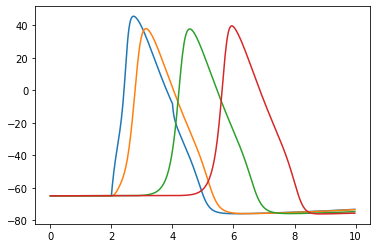

In [60]:
t = h.Vector().record(h._ref_t)
v = h.Vector().record(soma(0.5)._ref_v)
v1 = h.Vector().record(axon(0.1)._ref_v)
v2 = h.Vector().record(axon(0.5)._ref_v)
v3 = h.Vector().record(axon(0.9)._ref_v)

h.finitialize(-65*mV)
h.continuerun(10*ms)

#plt.plot(t, v)
idxs = slice(0, -1)
t = np.array(t)
v = np.array(v)
v1 = np.array(v1)
v2 = np.array(v2)
v3 = np.array(v3)
plt.plot(t[idxs], v[idxs])
plt.plot(t[idxs], v1[idxs])
plt.plot(t[idxs], v2[idxs])
plt.plot(t[idxs], v3[idxs])

In [4]:
for sec in h.allsec():
    print(sec)

soma
axon


In [12]:
T = 20
dt = 0.03125

cell = LFPy.Cell(morphology=h.allsec(), v_init=-65, pt3d=True, tstart=0, dt=dt, tstop=T)

Morphology:  <all section iterator next>
Type:  <class 'hoc.HocObject'>


In [16]:
cell.simulate(rec_imem=True, rec_vmem=True)

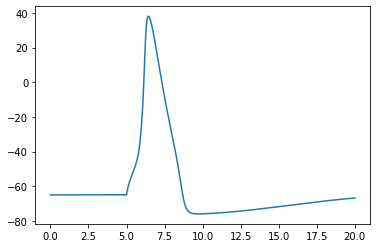

In [17]:
plt.plot(np.arange(0, T+dt, dt), cell.somav)

In [15]:
syn = h.IClamp(0.5, sec=soma)
syn.dur = 1
syn.delay = 5

weight = 0.25
tot_ntsteps = int(round(T / dt + 1))
I = np.ones(tot_ntsteps) * weight
noiseVec = h.Vector(I)

noiseVec.play(syn._ref_amp, dt)

Vector[47]

In [8]:
cell.imem

array([[-3.03237092e-05,  4.49182283e-18, -8.62174525e-19, ...,
        -6.20958592e-04, -6.17833383e-04, -6.14725825e-04],
       [-3.03237092e-05,  1.15564839e-18, -2.17951232e-19, ...,
        -2.88719742e-04, -2.87264905e-04, -2.85818965e-04],
       [-3.03237092e-05,  4.30833831e-19, -9.12353995e-20, ...,
        -2.58894487e-04, -2.57570076e-04, -2.56256281e-04],
       ...,
       [-3.03237092e-05, -5.06863330e-21, -5.06863330e-21, ...,
         2.93540731e-04,  2.92020656e-04,  2.90500655e-04],
       [-3.03237092e-05, -5.06863330e-21, -5.06863330e-21, ...,
         3.16728009e-04,  3.15093094e-04,  3.13458218e-04],
       [-3.03237092e-05,  0.00000000e+00,  5.06863330e-21, ...,
         3.29530975e-04,  3.27832272e-04,  3.26133622e-04]])

In [9]:
np.shape(cell.imem)

(22, 641)

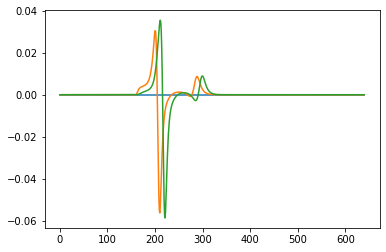

In [18]:
plt.plot(cell.imem[0])
plt.plot(cell.imem[20])
plt.plot(cell.imem[40])

In [103]:
np.shape(cell.imem)

(102, 641)

In [98]:
for sec in cell.allseclist:
    print(sec.nseg)

1
101


In [14]:
axon.nseg = 101

In [9]:
syn._ref_amp

<pointer to hoc scalar 0>

In [13]:
axon.nseg

21

In [17]:
dir(cell)

['Ra',
 '_Cell__calc_totnsegs',
 '_Cell__check_currents',
 '_Cell__collect_tvec',
 '_Cell__collect_vstim',
 '_Cell__get_idx',
 '_Cell__purge_hoc_pointprocesses',
 '_Cell__run_custom_codes',
 '_Cell__run_simulation',
 '_Cell__set_current_dipole_moment_array',
 '_Cell__set_extracellular',
 '_Cell__set_ipointprocess_recorders',
 '_Cell__set_isyn_recorders',
 '_Cell__set_negs',
 '_Cell__set_nsegs_fixed_length',
 '_Cell__set_nsegs_lambda100',
 '_Cell__set_nsegs_lambda_f',
 '_Cell__set_passive',
 '_Cell__set_ra_and_cm',
 '_Cell__set_time_recorders',
 '_Cell__set_vpointprocess_recorders',
 '_Cell__set_vsyn_recorders',
 '_Cell__update_synapse_positions',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',


In [24]:
np.shape(cell.y3d)

(2, 3)

In [25]:
cell.y3d

[array([ 6.123234e-16,  0.000000e+00, -6.123234e-16]),
 array([ 6.12323400e-16, -7.54979046e-05, -1.50995809e-04])]

In [6]:
for sec in cell.allseclist:
    print(np.shape(sec.x3d))

()
()


In [31]:
dir(sec)

['L',
 'Ra',
 '__call__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'allseg',
 'arc3d',
 'cell',
 'children',
 'connect',
 'diam3d',
 'disconnect',
 'has_membrane',
 'hname',
 'hoc_internal_name',
 'insert',
 'is_pysec',
 'n3d',
 'name',
 'nseg',
 'orientation',
 'parentseg',
 'psection',
 'pt3dadd',
 'pt3dchange',
 'pt3dclear',
 'pt3dinsert',
 'pt3dremove',
 'pt3dstyle',
 'push',
 'rallbranch',
 'same',
 'spine3d',
 'subtree',
 'trueparentseg',
 'uninsert',
 'wholetree',
 'x3d',
 'y3d',
 'z3d']

In [7]:
sec.n3d()

303

In [15]:
np.shape(cell.imem)

AttributeError: 'Cell' object has no attribute 'imem'

In [21]:
sec.n3d()

303

In [20]:
sec.x3d(100)

-335.5647888183594

In [22]:
allx = []
for i in range(sec.n3d()):
    allx.append(sec.x3d(i))

In [10]:
np.shape(cell.imem)

(302, 641)

In [13]:
axon.nseg

301

In [14]:
cell._update_pt3d()

ValueError: could not broadcast input array from shape (301,) into shape (11,)

In [23]:
cell.x3d, cell.y3d, cell.z3d, cell.diam3d = cell._collect_pt3d()

In [24]:
cell._update_pt3d()

ValueError: could not broadcast input array from shape (301,) into shape (11,)

In [17]:
cell.x3d

[array([-10., -10., -10.]),
 array([-10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        , -10.        ,
        -10.        , -10.        , -10.        ,  -9.99996948,
         -9.99996948,  -9.99996948,  -9.99996948,  -9.99996948,
         -9.99996948,  -9.99996948,  -9.99996948,  -9.99996948,
         -9.99996948,  -9.99996948,  -9.99996948,  -9.99996948,
         -9.99996948,  -9.99996948,  -9.99996948,  -9.99996948,
         -9.99996948,  -9.99996948,  -9.99996948,  -9.99996948,
         -9.99996948,  -9.99996948,  -9.99996948,  -9.99996948,
         -9.99996948,  -9.99996948,  -9.99996948,  -9.99996948,
         -9.

In [31]:
for sec in cell.allseclist:
    print(h.n3d(sec=sec))

3.0
303.0


In [69]:
r = np.arange(0, 1000, 1)
y = 0.5/(r**2)

logy = np.log10(y)
logr = np.log10(r)

roc = (logy[1:] - logy[:-1])/(logr[1:] - logr[:-1])

/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_46118/3991316928.py:2: RuntimeWarning: divide by zero encountered in true_divide
  y = 0.5/(r**2)
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_46118/3991316928.py:5: RuntimeWarning: divide by zero encountered in log10
  logr = np.log10(r)
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_46118/3991316928.py:7: RuntimeWarning: invalid value encountered in true_divide
  roc = (logy[1:] - logy[:-1])/(logr[1:] - logr[:-1])


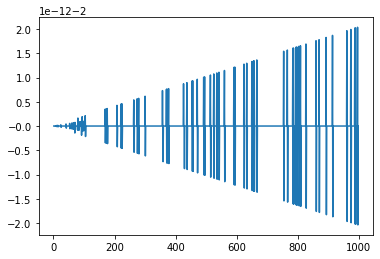

In [70]:
plt.plot(roc)

In [71]:
roc

array([nan, -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2

In [73]:
electrodes.z

array([-499.5, -498.5, -497.5, -496.5, -495.5, -494.5, -493.5, -492.5,
       -491.5, -490.5, -489.5, -488.5, -487.5, -486.5, -485.5, -484.5,
       -483.5, -482.5, -481.5, -480.5, -479.5, -478.5, -477.5, -476.5,
       -475.5, -474.5, -473.5, -472.5, -471.5, -470.5, -469.5, -468.5,
       -467.5, -466.5, -465.5, -464.5, -463.5, -462.5, -461.5, -460.5,
       -459.5, -458.5, -457.5, -456.5, -455.5, -454.5, -453.5, -452.5,
       -451.5, -450.5, -449.5, -448.5, -447.5, -446.5, -445.5, -444.5,
       -443.5, -442.5, -441.5, -440.5, -439.5, -438.5, -437.5, -436.5,
       -435.5, -434.5, -433.5, -432.5, -431.5, -430.5, -429.5, -428.5,
       -427.5, -426.5, -425.5, -424.5, -423.5, -422.5, -421.5, -420.5,
       -419.5, -418.5, -417.5, -416.5, -415.5, -414.5, -413.5, -412.5,
       -411.5, -410.5, -409.5, -408.5, -407.5, -406.5, -405.5, -404.5,
       -403.5, -402.5, -401.5, -400.5, -399.5, -398.5, -397.5, -396.5,
       -395.5, -394.5, -393.5, -392.5, -391.5, -390.5, -389.5, -388.5,
      

In [63]:
dir(axon)

['L',
 'Ra',
 '__call__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'allseg',
 'arc3d',
 'cell',
 'children',
 'connect',
 'diam3d',
 'disconnect',
 'has_membrane',
 'hname',
 'hoc_internal_name',
 'insert',
 'is_pysec',
 'n3d',
 'name',
 'nseg',
 'orientation',
 'parentseg',
 'psection',
 'pt3dadd',
 'pt3dchange',
 'pt3dclear',
 'pt3dinsert',
 'pt3dremove',
 'pt3dstyle',
 'push',
 'rallbranch',
 'same',
 'spine3d',
 'subtree',
 'trueparentseg',
 'uninsert',
 'wholetree',
 'x3d',
 'y3d',
 'z3d']

In [68]:
for seg in axon.allseg():
    print(a.diam)

4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


In [67]:
dir(a)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'area',
 'cm',
 'diam',
 'node_index',
 'point_processes',
 'ri',
 'sec',
 'v',
 'volume',
 'x']

In [76]:
np.arange(1, 4+0.1, (4-1)/9)

array([1.        , 1.33333333, 1.66666667, 2.        , 2.33333333,
       2.66666667, 3.        , 3.33333333, 3.66666667, 4.        ])

In [87]:
axon.diam3d(10)

4.0

In [28]:
i = 0
for seg in axon.allseg():
    print(i, seg.diam)
    i = i + 1

0 4.0
1 4.0
2 4.0
3 4.0
4 4.0
5 4.0
6 4.0
7 4.0
8 4.0
9 4.0
10 4.0
11 4.0
12 4.0
13 4.0
14 4.0
15 4.0
16 4.0
17 4.0
18 4.0
19 4.0
20 4.0
21 4.0
22 4.0
23 4.0
24 4.0
25 4.0
26 4.0
27 4.0
28 4.0
29 4.0
30 4.0
31 4.0
32 4.0
33 4.0
34 4.0
35 4.0
36 4.0
37 4.0
38 4.0
39 4.0
40 4.0
41 4.0
42 4.0
43 4.0
44 4.0
45 4.0
46 4.0
47 4.0
48 4.0
49 4.0
50 4.0
51 4.0
52 4.0
53 4.0
54 4.0
55 4.0
56 4.0
57 4.0
58 4.0
59 4.0
60 4.0
61 4.0
62 4.0
63 4.0
64 4.0
65 3.9999999999999427
66 4.000000000000057
67 3.9999999999999427
68 4.000000000000057
69 3.9999999999999427
70 4.000000000000057
71 3.9999999999999427
72 4.000000000000057
73 3.9999999999999427
74 4.000000000000057
75 3.9999999999999427
76 4.000000000000057
77 3.9999999999999427
78 4.000000000000057
79 3.9999999999999427
80 4.000000000000057
81 3.9999999999999427
82 4.000000000000057
83 3.9999999999999427
84 4.000000000000057
85 3.9999999999999427
86 4.000000000000057
87 3.9999999999999427
88 4.000000000000057
89 3.9999999999999427
90 4.000000000000

In [15]:
axon.diam3d(500)

1.00600004196167

In [17]:
for sec in cell.allseclist:
    for seg in sec.allseg():
        print(seg.diam)

10.0
10.0
10.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.000000000000057
3.9999999999999427
4.0

In [19]:
for seg in axon.allseg():
    print(seg)

axon(0)
axon(0.000998004)
axon(0.00299401)
axon(0.00499002)
axon(0.00698603)
axon(0.00898204)
axon(0.010978)
axon(0.0129741)
axon(0.0149701)
axon(0.0169661)
axon(0.0189621)
axon(0.0209581)
axon(0.0229541)
axon(0.0249501)
axon(0.0269461)
axon(0.0289421)
axon(0.0309381)
axon(0.0329341)
axon(0.0349301)
axon(0.0369261)
axon(0.0389222)
axon(0.0409182)
axon(0.0429142)
axon(0.0449102)
axon(0.0469062)
axon(0.0489022)
axon(0.0508982)
axon(0.0528942)
axon(0.0548902)
axon(0.0568862)
axon(0.0588822)
axon(0.0608782)
axon(0.0628743)
axon(0.0648703)
axon(0.0668663)
axon(0.0688623)
axon(0.0708583)
axon(0.0728543)
axon(0.0748503)
axon(0.0768463)
axon(0.0788423)
axon(0.0808383)
axon(0.0828343)
axon(0.0848303)
axon(0.0868263)
axon(0.0888224)
axon(0.0908184)
axon(0.0928144)
axon(0.0948104)
axon(0.0968064)
axon(0.0988024)
axon(0.100798)
axon(0.102794)
axon(0.10479)
axon(0.106786)
axon(0.108782)
axon(0.110778)
axon(0.112774)
axon(0.11477)
axon(0.116766)
axon(0.118762)
axon(0.120758)
axon(0.122754)
axon(0.12

In [20]:
dir(seg)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'area',
 'cm',
 'diam',
 'node_index',
 'point_processes',
 'ri',
 'sec',
 'v',
 'volume',
 'x']

In [37]:
for p in seg.point_processes():
    print(p)

In [32]:
seg._ref_mtau_hh()

AttributeError: _ref_mtau_hh was not made to point to anything at axon(0.5)

In [39]:
dir(seg.hh)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'el',
 'gk',
 'gkbar',
 'gl',
 'gna',
 'gnabar',
 'h',
 'il',
 'is_ion',
 'm',
 'n',
 'name',
 'segment']

In [16]:
seg.hh.gkbar

0.036

In [13]:
seg = axon(0.5)

In [69]:
axon.diam3d(500)

1.0061099529266357